### Pricing American Options with Montecarlo ###

# Part 3 - Stochastic Mesh #

In [2]:
import math
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import scipy.stats       as ss

%matplotlib inline

# local module
from gdl_finance.analytic import BlackScholes
from gdl_finance.trees    import *

## <span style='color:Blue'> Introduction </span> ##

As we have seen in the previous lesson, Broadie and Glasserman (1997) developed a method based on random trees. Their method, which has the advantage of a solid theoretical background, generates two estimators, a lower bound and an upper bound (i.e., one biased low and one biased high), with both estimators convergent and asymptotically unbiased as the computational eﬀort increases. A valid conﬁdence interval for the true American price is obtained by taking the upper conﬁdence limit from the “high” estimator and the lower conﬁdence limit from the “low” estimator. The main drawback of this method was that the work is exponential in the number of exercise opportunities.

After that, the authors proposed another method based on a stocastich mesh when there is a ﬁnite, but possibly large, number of exercise dates. The method provides lower and upper bounds, conﬁdence intervals for the true price, and it converges as the computational eﬀort increases. The work of the algorithm is linear in the number of state variables, linear in the number of exercise opportunities, and quadratic in the number of points in the mesh. The linear, rather than exponential, dependence on the number of exercise dates is in marked contrast to the random tree method. 

Like the stochastic tree algorithm the stochastic mesh method is designed to solve a randomly sampled dynamic programming problem to approximate the price of an American option.

In these methods the trajectories simulation are like what is being done in regression-based methods and approximating continuation values are somehow like random tree methods.

![caption](img/lesson_2/stochastic_mesh_1.PNG)

### *Drawing a Stochastic Mesh* ###

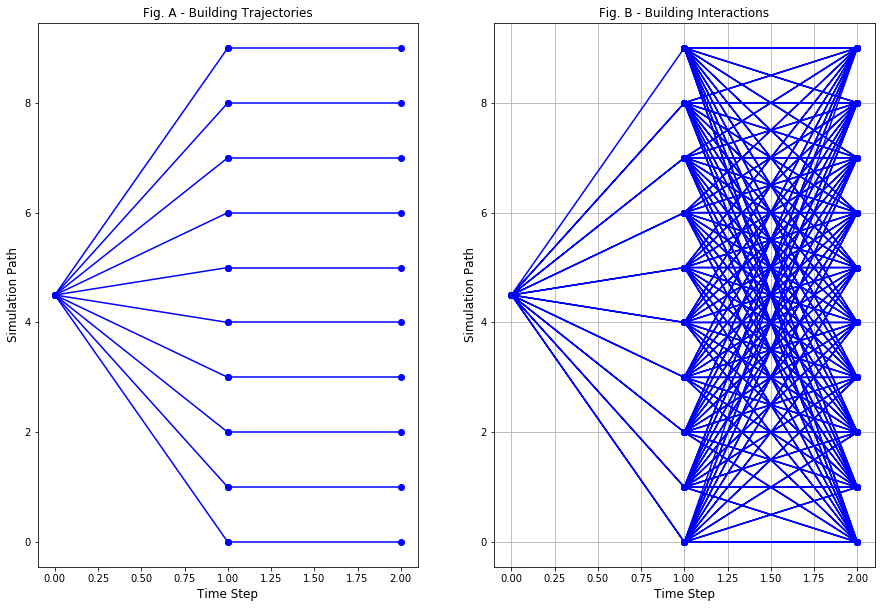

In [5]:
mesh(2,10)

In Figure above the simulations and approximation process is shown with two diagrams. In Figure (a) the way of trajectories simulation is shown. It shows that each trajectory is actually a Markov chain in which states are only dependent on their previous states in the same trajectory. So states from diﬀerent trajectories, or from states more than one states after or before a state, are independent. Figure (b) shows which states help us to approximate the continuation values of any arbitrary state (in each states, continuation value approximation is dependent on those states that has a line to it and are in the next time step).


## <span style='color:Blue'> Building Mesh </span> ##

In random tree methods, the process of approximating continuation values of a state is done according to states in next step which are only successors of it. But in stochastic mesh methods all the states in the next step are interfering. Due to this property it maintains the number of nodes at each time step fixed thus avoiding the exponential growth characteristic of the stochastic tree.

The general approach in stochastic mesh methods is as follows.

The option value in ﬁnal step states are computed as

\begin{equation}
\hat Q(T, X_{T, j}) = h(T, X_{T, j})
\end{equation}

for $j=1,2,\dots,b$. Recursively, for previous steps consider that we want to approximate the continuation value in a state $(i, j)$ with price $X_{i,j}$ . The diagram in Figure (b) shows that it can be dependent on option values in states 
$(i+1,1),(i+1,2),\dots,(i+1,b)$ (it actually can be dependent on all of them or just a number of them).

In general we have two different probability functions whose specification is an integral part of the parameterization of the mesh. The first one is $f(t, x, ·)$ that denote the density of $S_{t+1}$ given $S_t = x$, the second one, $g(t, ·)$, will denote the marginal density of $S_t$ (with $S_0$ ﬁxed). To state precisely this two definitions, let

$$X_i =(X_{i1}, \dots, X_{ib})$$

denote the "mesh state" at step $i$ consisting of all nodes at step $i$, for $i=1,\dots,m$, the initial value will be simply indicated as $X_0$. The mesh construction is *markovian* in the sense that $\{X_0, \dots, X_{i-1}\}$ and 
$\{X_{i+1}, \dots, X_m\}$ are independent given $X_i$ for all $i$. In this setting, the probability density function $f$ is the **transition density** of the markov chain meaning that for some $A \subseteq \mathbb{R}^b$ and 
$x \in \mathbb{R}^b$

$$\mathbb{P} (X_i \in A \vert X_{i-1} =x) = \int_A f_i(x,y)\, dy \quad i=1,\dots,m  $$

What is the relationship between transition and marginal density? For the first step, with $X_0$ fixed obviously the marginal density of $X_1$ is exactly the transition density in the sense that

$$g_1(.) = f_1(X_0,.)$$

Similarly we can calculate the marginal probabilities of each $X_i$ recursively. Let's start from the simple discrete version

$$
\mathbb{P}(X_i = y) = \sum\limits_x \mathbb{P}(X_{i-1}= x) \mathbb{P}(X_i = y \vert X_{i-1}=x)
$$

which becomes

$$
g_i(y) = \int g_{i-1}(x) f_i(x,y)\,dy
$$

Note that the optimal continuation value in state $x$ at time $i$ is given by

\begin{equation}
C_i(x) = \mathbb{E} \left[ V_{i+1}(X_{i+1} \vert X_i=x)  \right] = \int V_{i+1}(y) f_{i+1}(x,y)\, dy
\label{eqn:mesh_equation_1}
\end{equation}

which is <span style='color:Blue'> **an integral with respect to a transition density** </span>. 

Now, the question is: <span style='background :yellow' >can we assume for the continuation value a simple estimator like this</span>

\begin{equation}
\frac{1}{b} \sum\limits_{k=1}^b V_{i+1}(X_{i+1,k})
\label{eqn:mesh_equation_2}
\end{equation}

as we have done in the case of the random tree?

<span style='background :yellow' >The answer is no</span>, let's see why. Fix a node $X_{i,j}$ in the mesh and consider the estimation of the continuation value at that node, suppose that the nodes $X_{i+1,k} \, k=1,\dots,b$ at the next step in the mesh were generated independently of each other and of all othe nodes in the mesh. Suppose also that we know the true option values $V_{i+1}(X_{i+1,k})$ at these nodes. Averaging over the $b$ nodes at step $i+1$ and letting $b\rightarrow \infty$ yields

$$
\frac{1}{b} \sum\limits_{k=1}^b V_{i+1}(X_{i+1,k}) \rightarrow \int V_{i+1}(y) g(y)\, dy
$$

which will not in general equal the desired continuation value from $\eqref{eqn:mesh_equation_1}$. The idea is to take as estimation of the continuation value a weighted average, so, instead of $\eqref{eqn:mesh_equation_2}$ we are going to work with the following general estimator

\begin{equation}
\frac{1}{b} \sum\limits_{k=1}^b W_{j,k}^i V_{i+1}(X_{i+1,k})
\label{eqn:mesh_equation_3}
\end{equation}

In particular, if we set each weight to be

\begin{equation}
W_{j,k}^i = \frac{f_{i+1}\left(X_{i,j},X_{i+1,k} \right) }{g\left(X_{i+1,k} \right)}
\end{equation}

the likelihood ratio relating the transition density to the mesh marginal density $g$ we have

\begin{align}
\frac{1}{b} \sum\limits_{k=1}^b W_{j,k}^i V_{i+1}(X_{i+1,k}) &\rightarrow \mathbb{E}_g \left[ W_{j,k}^i V_{i+1}(X_{i+1,k} \vert X_{i,j}\right] \notag\\
&= \int \frac{f_{i+1}\left(X_{i,j},y \right) }{g\left(y \right)} V_{i+1}(y) g(y)\, dy\notag\\
&= \int f_{i+1}\left(X_{i,j},y \right)V_{i+1}(y) \, dy\notag\\
&= C_i(X_{i,j})
\end{align}

which is what we wanted. 

Even if we fix the mechanism used to generate the mesh, there is some flexibility in the choice of the likelihood ratio weights in particular as regards the choice of the marginal density $g$ which is strongly related to the way we choose to build our mesh.

### *Selection of the Mesh Density* ###

As described in the previous section, the stochastic mesh method leaves some freedom in implementation. The correct selection of the density used to generate the mesh is essential to exploit efficiencies in the computation of the estimates. In order to present the impact that the density function may have on the estimator’s variance Broadie and Glasserman (2004) considered the pricing through the mesh of a European style derivative with three years to maturity. Since early exercise is not allowed, the mesh estimator of the european option price simplifies to

\begin{equation}
\hat Q(t, X_t(i)) = \frac{1}{b}\sum\limits_{j=1}^b \hat Q(t+1, X_{t+1}(j)) \frac{f(t,X_t(i), X_{t+1}(j)}{g(t+1,X_{t+1}(j)}
\end{equation}

They considered, as an example, the case $T=3$, in this case $\hat Q(0,S_0)$ can be written as

\begin{align}
\hat Q(0, X_{0}) 
&=\frac{1}{b} \sum\limits_{j_1=1}^b 
\frac{f(0,X_0,X_{1,j_1})}{g(1,X_{1,j_1})}
\hat Q(1, X_{1, j_1}) \notag\\
&= \frac{1}{b} \sum\limits_{j_1=1}^b 
\frac{f(0,X_0,X_{1,j_1})}{g(1,X_{1,j_1})}
\left[
\frac{1}{b} \sum\limits_{j_2=1}^b 
\frac{f(1,X_{1,j_1},X_{2,j_2})}{g(2,X_{2,j_2})}
\hat Q(2, X_{2, j_2})
\right] \notag\\
&=\frac{1}{b} \sum\limits_{j_1=1}^b 
\frac{f(0,X_0,X_{1,j_1})}{g(1,X_{1,j_1})}
\left[
\frac{1}{b} \sum\limits_{j_2=1}^b 
\frac{f(1,X_{1,j_1},X_{2,j_2})}{g(2,X_{2,j_2})}
\left[
\frac{1}{b} \sum\limits_{j_3=1}^b 
\frac{f(2,X_{2,j_2},X_{T,j_3})}{g(T,X_{T,j_3})}
\hat h(T, X_{T, j_3})
\right]
\right] \notag\\
&=\frac{1}{b} \sum\limits_{j_3=1}^b  \hat h(T, X_{T, j_3})
\left[
\frac{1}{b} \sum\limits_{j_2=1}^b 
\frac{f(2,X_{2,j_2},X_{T,j_3})}{g(T,X_{T,j_3})}
\left[
\frac{1}{b} \sum\limits_{j_1=1}^b 
\frac{f(1,X_{1,j_1},X_{2,j_2})}{g(2,X_{2,j_2})}
\frac{f(0,X_0,X_{1,j_1})}{g(1,X_{1,j_1})}
\right]
\right]
\label{eqn:mesh_equation_4}
\end{align}

The last line demonstrates that the mesh estimator is just a linear combination of the maturity payoffs. Generalizing for an arbitrary T the European option price can be written as:

$$
\hat Q(0, X_{0})  = \frac{1}{b}\sum\limits_{j_T=1}^b h(T, X_T(j_T))\, L(T,j_T)
$$

where

\begin{equation}
L(T, j_T)=\frac{1}{b^{T-1}} \sum\limits_{j_1, \dots, j_{T-1}}^b \left(   
\prod\limits_{i=1}^T \frac{f(i-1,X_{i-1}(j_{i-1}), X_{i}(j_{i}))}{g(i,X_{i}(j_{i})}
\right)
\label{eqn:mesh_equation_5}
\end{equation}

Now we have  to choose wisely how to define density. Let's take into consideration the last line of equation $\eqref{eqn:mesh_equation_4}$ 

\begin{equation}
\hat Q(0, X_{0}) 
=\frac{1}{b} \sum\limits_{j_3=1}^b  \hat h(T, X_{T, j_3})
\left[
\frac{1}{b} \sum\limits_{j_2=1}^b 
\frac{f(2,X_{2,j_2},X_{T,j_3})}{g(T,X_{T,j_3})}
\left[
\frac{1}{b} \sum\limits_{j_1=1}^b 
\frac{f(1,X_{1,j_1},X_{2,j_2})}{g(2,X_{2,j_2})}
\boxed{
\frac{f(0,X_0,X_{1,j_1})}{g(1,X_{1,j_1})}
}
\right]
\right]
\notag
\end{equation}

if we choose $g(1,X_{1,j_1}) = f(0,X_0,X_{1,j_1})$, the boxed term reduced to $1$ and the term in the last square bracket is simply

$$
\frac{1}{b} \sum\limits_{j_1=1}^b 
\frac{f(1,X_{1,j_1},X_{2,j_2})}{g(2,X_{2,j_2})} =
 \frac{1}{g(2,X_{2,j_2})} \frac{1}{b} \sum\limits_{j_1=1}^b  f(1,X_{1,j_1},X_{2,j_2})
$$

choosing 

$$
g\left(2,X_{2,j_2}\right) = \frac{1}{b} \sum\limits_{j_1=1}^b  f(1,X_{1,j_1},X_{2,j_2})
$$

makes also this term egual to $1$. So it's easy to see that if we choose

\begin{equation}
g(t,u) = f(0,S_0,u) \quad \text{for} \quad t=1
\end{equation}

\begin{equation}
g(t,u) = \frac{1}{b} \sum\limits_{j=1}^b  f(t-1,X_{t-1,j},u) \quad \text{for} \quad t=2,\dots,T
\label{eqn:average_density}
\end{equation}

the mesh so generated has the attractive feature that the estimate it provides of the European value of an option is simply the average of the terminal payoffs. This choice has also another advantage. Brodie and Glasserman state that in general the likelihood ratio given by $\eqref{eqn:mesh_equation_5}$ could possibly have infinite variance. The average density method defined above is significant because it eliminates this risk.

## <span style='color:Blue'> High Bias Estimator </span> ##

Our first estimator will be then 

\begin{equation}
\hat Q(t, X_{t, i}) = \max
\left[
h(t, X_{t, i}),
\frac{1}{b} \sum\limits_{j=1}^b \hat Q(t+1, X_{t+1, j})
w(t, X_{t,i}, X_{t+1,j})
\right]
\label{eqn:estimator_high}
\end{equation}

where $w(t, X_{t,i}, X_{t+1,j})$ represents the weight attached to the arc joining node $X_{t,i}$ with node $X_{t+1,j}$ and is defined by

\begin{equation}
w(t, X_{t,i}, X_{t+1, j}) = 
\frac{f\left(t, X_{t,i}, X_{t+1,j}\right)}{\frac{1}{b}\sum\limits_{k=1}^n
f\left(t, X_{t,k}, X_{t+1,j}\right)}
\end{equation}


Finally for time $0$:

\begin{equation}
\hat Q(0, X_{0})=\frac{1}{b} \sum\limits_{i=1}^b \hat Q(1, X_{1, i})
\end{equation}

Broadie and Glasserman (1997) and Glasserman (1999), using the same procedure followed for the stochastic tree method, demonstrated that this estimator is indeed high biased.

It is noteworthy to note that the idea of simulating independent paths and then interconnecting them with weights in order to apply dynamic programming is also implicit in the methods of Longstaff and Schwartz; their weights are produced implicitly by a least squares procedure. Thus although arrived at by a different argument, those methods may be viewed as stochastic mesh methods with different choices for weights. 

### *Random Vectors Generation and Weights Determination* ###

Using the average density method to generate the mesh can be interpreted in the following way. 

Suppose that from each of the mesh nodes $X_{t-1}(j), j = 1, \dots , b$, we generate exactly one successor $X_t(j)$ from the underlying transition density $f(t-1,X_{t-1}(j),·)$. If we then draw a value randomly and uniformly from $\{X_t(1), \dots , X_t(b)\}$, the value drawn is distributed according to the average density $g(t, ·)$ in $\eqref{eqn:average_density}$, conditional on $\{X_{t-1}(1), \dots , X_{t-1}(b)\}$. Using the average density is thus equivalent to generating $b$ independent paths of the underlying and then “forgetting” which nodes were on which paths.


Taking this observation one step further leads to the following implementation: simulate $b$ independent paths $(X_0(i), \dots , X_T (i)), i = 1, \dots , b$, as in an ordinary simulation and then apply the weight
\begin{equation}
w(t, X_{t,i}, X_{t+1, j}) = 
\frac{f\left(t, X_{t,i}, X_{t+1,j}\right)}{\frac{1}{b}\sum\limits_{k=1}^n
f\left(t, X_{t,k}, X_{t+1,j}\right)}
\notag
\end{equation}
to the transition from $X_{t-1}(i)$ on the $i-th$ path to $X_t(j)$ on the $j-th$ path. These weights define the mesh.

Let's see a very simple example of implementation.

#### Path Generation ####

In [1]:
from scipy.stats import norm 

# Financial Parameters
S0     =  90.0   # initial stock level
K      = 100.0   # strike price
T      =   1.0   # time-to-maturity
r      =   0.00  # short rate
sigma  =   0.20  # volatility
delta  =   0.0   # dividend yield
payout =   1     # 1 for call option, -1 for put option 

# Simulation Parameters
b  = 10                     # branching parameter (must be an even number!!!)
n  = 1000                   # Monte Carlo reiterations
t  = [0.,1./3.,2./3.,1.]    # exercise opportunities
dt = t[1]-t[0]

drift = (r - delta - .5 * sigma**2) * dt
european_option = BlackScholes(payout, S0, K, r,delta,sigma, T)
#
# ----- 1st exercise data -----------------------------------------------
#
z1  = np.random.randn(b,n)
#
S1 = S0 * np.exp((r - delta - 0.5 * sigma ** 2) * dt 
       + sigma * math.sqrt(dt) * z1)
#
# ----- 2nd exercise data -----------------------------------------------
#
z2  = np.random.randn(b,n)
#
S2 = S1 * np.exp((r - delta - 0.5 * sigma ** 2) * dt 
           + sigma * math.sqrt(dt) * z2)


NameError: name 'BlackScholes' is not defined

In [ ]:
print(S1[:,0])

In [ ]:
print(S2[:,0])

In [ ]:
if b <= 15:
    fig = plt.figure(figsize=[20, 10])

    S = np.concatenate((S1, S2))
    labels = ["%.2f" % S0]
    labels.extend(["%.2f" % member for member in list(S[:,0])])
    labels.extend(1000*['ND'])

    l = len(t) - 1
    # 
    # calculating tree points coordinates
    #
    x       = [0]
    y       = [float((b - 1))/2.0]
    for i in range(1,l + 1):
        for j in range(b):
            x.append(i)
            y.append(j)
    #
    # setting labels
    #
    for k in range(len(x)):
        plt.text(x[k]-0.1,y[k]+0.1,labels[k])    
    #
    # building trajectories
    #
    x_old = b * [(x[0])]
    y_old = b * [(y[0])]
    for i in range(1, l + 1):
        imax = b*i 
        imin = imax - b + 1
        x_new = x[imin:imax+1]
        y_new = y[imin:imax+1]
        for j in range(len(x_new)):
            x_plt = []
            y_plt = []
            x_plt.append(x_old[j])
            x_plt.append(x_new[j])
            y_plt.append(y_old[j])
            y_plt.append(y_new[j])
            plt.plot(x_plt, y_plt, 'bo-')

        x_old = x_new
        y_old = y_new
    plt.grid(True)
    plt.show()

#### Weights Calculation ####

In [ ]:
# Time t2 = T - 1
#
# calculating mesh
#
con_high_2 = BlackScholes(payout, S2, K, r, delta, sigma, 1./3.) 
exe_high_2 = np.maximum(payout*(S2 - K), 0)   
Q2         = np.maximum(exe_high_2, con_high_2)

We have used, as usual, a log-normal transition probability 

\begin{equation}
f(t, X_{t,i}, X_{t+1,j}) = 
\frac{1}{X_{t+1,j}\sigma \sqrt{dt} \sqrt{2\pi}} \exp \left(-{\frac {\left(\ln \frac{X_{t+1,j}}{X_{t,i}}-\left(\mu -{\frac {1}{2}}\sigma ^{2}\right)t\right)^{2}}{2\sigma ^{2}t}}\right)
= \frac{1}{X_{t+1,j}\sigma \sqrt{dt}} \cdot \text{norm.pdf}
\left(
\frac {\ln \frac{X_{t+1,j}}{X_{t,i}}
-\left(\mu -{\frac {1}{2}}\sigma^2\right)\,dt }
{2\sigma \sqrt{dt}}
\right)
\end{equation}



In [ ]:
#
# calculating densities
#
density = np.zeros((b, b, n))
for i in range(0, b):
    for j in range(0, b):
        c    = 1.0/(sigma * np.sqrt(dt) * S2[j,:])
        arg  = (np.log(S2[j,:]/S1[i,:]) - drift)/(sigma * np.sqrt(dt))
        density[i, j,:] = c * norm.pdf(arg)

Remember weights definition:

\begin{equation}
w(t, X_{t,i}, X_{t+1, j}) = 
\frac{f\left(t, X_{t,i}, X_{t+1,j}\right)}{\frac{1}{b}\sum\limits_{k=1}^n
f\left(t, X_{t,k}, X_{t+1,j}\right)}
\end{equation}

In [13]:
#
# calculating weights
#
weights = np.zeros((b, b, n))
for i in range(0, b):
    for j in range(0, b):
        somma = np.divide(np.sum(density[:,j,:], axis=0), b)
        weights[i, j,:] = np.divide(density[i, j,:], somma)

remember the definiton of the mesh estimator as

\begin{equation}
\hat Q (t, X_{t,i}) = \max \left(
h(t,X_{t,i}) , 
\frac{1}{b} \sum\limits_{j=1}^b
\hat Q (t+1, X_{t+1,j}) w(t, X_{t,i},X_{t+1,j})
\right) \quad \text{for} \> i = 1, \dots, b
\end{equation}

At time $t_1 = T - 2$ we have $\hat Q (t+1, .) = Q2$

In [14]:
#
# Time t1 = T - 2
#
Q1      = np.zeros((b,n))
for i in range(0, b):
    exer_1  = np.maximum(payout*(S1[i,:] - K), 0)  
    cont_1  = np.divide(np.sum(weights[i,:,:] * Q2 , axis=0), b) * math.exp(-r*dt)
    Q1[i,:] = np.maximum(exer_1, cont_1)
#
# Time T = 0
#
cont_3      = np.divide(np.sum(Q1, axis=0), b)
est_high    = np.maximum(payout*(S0 - K), cont_3)

In [15]:
print('value of high estimator :')
print("%.3f" % np.average(est_high))

value of high estimator :
3.815


## <span style='color:Blue'> Low Bias Estimator </span> ##

As in the case of the stochastic tree a low biased estimator may be computed. Then by combining it with the mesh estimator it is possible to produce a confidence interval for the option price. Broadie and Glasserman (1997) and Glasserman (2004) propose an estimator which is based on the approximation of the exercise region. To generate such estimator we simulate additional independent trajectories of the underlying process $S_t$ until the exercise region determined by the mesh is reached. An important feature of this estimator is that the mesh is used only to determine when to exercise. The payoff in case of exercise is determined by the independent path and it is not a value estimated from the mesh.

Starting from $t_0$ we begin the simulation of a new path of $S_t$ over many time steps $t=1,\dots,T$. Along this path, the approximate optimal policy determined by the mesh is:

\begin{equation}
\hat \tau(S) = \min \left\{ 
t:h(t,S_t) \ge \frac{1}{b} \sum\limits_{j=1}^b w(t, S_t, X_{t+1,j})
\hat Q(t+1, X_{t+1,j})
\right\}
\end{equation}

where $w(t, S_t, X_{t+1,j})$ is the weight from node $S_t$ on the independent path to node $X_{t+1,j}$ in the mesh. 

The path estimator is therefore

$$
\hat q = h(\hat \tau, S_{\hat \tau})
$$

In practice, after the simulation of the independent trajectory at each node we use $\eqref{eqn:estimator_high}$ with the new weights to estimate the option continuation value at that node and repeat this procedure until the estimated continuation value is lower than or equal to the exercise value, i.e. the exercise region is reached. The procedure is repeated over many paths and then averaged in order to produce an estimate of $\hat q$. 

An important insight is that the original mesh determines the optimal exercise boundary at all possible states and not only to those corresponding to nodes in the mesh. For this reason the exercise region determined by the mesh is not the optimal exercise region. Since it cannot be better than the optimal region because it is based on a finite sample the average payoff generated by this procedure cannot be greater than the average payoff determined optimally. We therefore conclude that the estimate produced by the path estimator is biased low. The convergence of the path estimator to the
true option price is stated in Theorem 4 in Broadie and Glasserman (2004).

In our implementation we will not follow this approach but we will use the technique proposed by Avramidis and Hyden (1999) which will allow us to reuse, at least from a conceptual point of view, what has been done with the stochastic tree.

The idea driving the construction of a new low biased estimate resembles the one already used for the low estimator in the stochastic tree, i.e. using disjoint sets of points for the estimation of the optimal exercise policy and the estimation of continuation values.

Suppose that $I \subseteq  b$ denotes an arbitrary subset of all indices and $I^\prime = b - I$ is its complement with respect to $b$ . The estimate of the continuation value at time $t$ is defined using only the points in $I$ at $t+1$ :

\begin{equation}
\hat C(t, X_{t,i}, I) = \frac{1}{\vert I \vert}
\sum\limits_{j \in I} \hat Q \left( t+1, X_{t+1,j}\right)
w\left(t, X_{t,i}, X_{t+1,j} \right)
\end{equation}

The consequent estimate of the option price at node $X_{t,i}$ is

\begin{equation}
\hat q_L(t, X_{t,i}, I)=\begin{cases} h(t,X_{t,i}), & \mbox{if } 
h(t,X_{t,i}) \ge \hat C(t, X_{t,i}, I) 
\\ \hat C(t, X_{t,i}, I^\prime), & \mbox{otherwise} 
\end{cases}
\end{equation}


In [16]:
#
# LOW ESTIMATOR ------------------------------------------------------------------------------
#
# Time t2 = T - 1
#
con_low_2    = BlackScholes(payout, S2, K, r,delta,sigma, 1./3.)
est_low_2    = np.maximum(payout*(S2-K), con_low_2)    

xx           = range(0, b)
weights_exe  = np.zeros((b, 1, n))
weights_con  = np.zeros((b, b-1, n))
Q_exe        = np.zeros((1,n))
Q_con        = np.zeros((b-1,n))
con          = np.zeros((b, b, n))
exe          = np.zeros((b, b, n))

In [17]:
#
# Time t1 = T - 2
#
# Weights estimation
#
for j1 in range(0, b):              
    y1      = [j1]
    y2      = np.delete(xx, y1)   
    Q_exe   = [est_low_2[l,:] for l in y1]
    Q_con   = [est_low_2[l,:] for l in y2] 
    for k in range(0,b):
        somma1 = np.divide(np.sum(density[:,j1,:], axis=0), b)
        weights_exe[k, 0, :] = np.divide(density[k, j1, :], somma1)
        m = 0
        for j2 in y2:
            somma = np.divide(np.sum(density[:,j2,:], axis=0), b)     
            weights_con[k, m, :] = np.divide(density[k, j2, :], somma)
            m += 1
            
        con[k, j1, :] = np.divide(np.sum(weights_con[k, :, :] * Q_con, axis=0), (b-1))    
        exe[k, j1, :] = np.sum(Q_exe * weights_exe[k, :, :], axis=0)


In [18]:
est         = np.zeros((b, b, n))       
est_low_1   = np.zeros((b, n))
for i in range(0, b):
    for k in range(0, b):
        for l in range(0, n):
            if np.maximum(payout*(S1[i,l]-K),0) >= con[i, k, l] * math.exp(-r*dt):
                est[i, k, l] = np.maximum(payout*(S1[i,l]-K),0)
            else:
                est[i, k, l] = exe[i, k, l] * math.exp(-r*dt)    
    est_low_1[i, :] = np.divide(np.sum(est[i], axis=0), b)    
    
somma   = np.divide(np.sum(est_low_1, axis=0), b) * math.exp(-r*dt)
est_low = np.maximum(payout*(S0-K), somma)

In [19]:
print('value of low estimator :')
print(str("%.3f" % np.average(est_low)))

value of low estimator :
3.360


In [20]:
final_estimate = 0.5 * est_high + 0.5 * est_low

std_err_h      = 1.96 * np.std(est_high)/np.sqrt(n)
std_err_l      = 1.96 * np.std(est_low) /np.sqrt(n)

est_low        = np.average(est_low)
est_high       = np.average(est_high)
final_estimate = np.average(final_estimate)

print('monte carlo sim  = ' + str(n))
print('branching        = ' + str(b))
print('stock price      = ' + str(S0))
print('high  estimator  = ' + str("%.3f" % est_high) + ' +/- ' + str("%.3f" % std_err_h)) 
print('low   estimator  = ' + str("%.3f" % est_low)  + ' +/- ' + str("%.3f" % std_err_h))
print('point estimator  = ' + str("%.3f" % final_estimate))
print('black scholes    = ' + str("%.3f" % european_option))
print('\n95% Confidence Interval')
print(str("%.3f" % (est_low - std_err_l)) + ' - ' + str("%.3f" % (est_high + std_err_h)))

monte carlo sim  = 1000
branching        = 10
stock price      = 90.0
high  estimator  = 3.815 +/- 0.120
low   estimator  = 3.360 +/- 0.120
point estimator  = 3.588
black scholes    = 3.589

95% Confidence Interval
3.247 - 3.935


## <span style='color:Blue'> References </span> ##

Avramidis A. N. and Hyden P.

**"Efficiency Improvements For Pricing American Options With A Stochastic Mesh"** 

*Proceedings of the 1999 Winter Simulation Conference P. A. Farrington, H. B. Nembhard, D. T. Sturrock, and G. W. Evans, eds*. 

---

Broadie M. and Glasserman P

**"A Stochastic Mesh Method for Pricing High-Dimensional American Options"**

*revised version of an article widely circulated as a working paper starting in 1997*

---

Glasserman P.

**"Monte Carlo Methods in Financial Engineering"**

*Springer (2004)*